This notebook is a work in progress. Proceed with caution. It is a medium complex analysis, and requires a lot of credits to run if you are doing this for entire states. 
This notebook can be easily scoped to more granular regions and recreated which will require less credits. 

You can expect to create interactive visuals like this: 

<p align="center">
  <img src="../../../images/density_map_of_price_changes.png" alt="Alt text">
</p>

### 1. Import the Parcl Labs Python Library

In [ ]:
# if needed, install and/or upgrade to the latest verison of the Parcl Labs Python library
%pip install --upgrade parcllabs

In [1]:
import os
import time
from itertools import islice
from datetime import timedelta

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from parcllabs import ParclLabsClient
from parcllabs.beta.charting.utils import create_labs_logo_dict
from parcllabs.beta.charting.styling import default_style_config as style_config


client = ParclLabsClient(
    api_key=os.environ.get('PARCL_LABS_API_KEY', "<your Parcl Labs API key if not set as environment variable>"), 
    limit=12 # set default limit
)

In [ ]:
# get all zips in florida
florida_zips = client.search.markets.retrieve(
    state_abbreviation='FL',
    location_type='ZIP5',
    limit=1000,
    auto_paginate=True,
    sort_by='TOTAL_POPULATION'
)

florida_zips

### 2. Retrieve Data

In [ ]:
# Set buy box criteria and zip code
PROPERTY_TYPE = 'single_family'

all_fl_props = []

# currently a throttle limit of 10 requests per minute
for idx, zip in enumerate(florida_zips['name'].tolist()):
    if idx % 10 == 0 and idx != 0:
        print(f"Processed {idx} requests. Waiting to avoid rate limit...")
        time.sleep(60)  # Wait for 60 seconds to avoid rate limit
        
    print(f"Processing {zip}...{idx}")

    try:
        unit_ids = client.property.search.retrieve(
            property_type=PROPERTY_TYPE,
            zip=zip
        )
        all_fl_props.append(unit_ids)
    except Exception as e:
        print(f"Error processing {zip}: {e}")
        continue

print("Completed processing all zip codes.")


In [ ]:
parcl_property_ids = pd.concat(all_fl_props)['parcl_property_id'].tolist()


In [ ]:
# Concatenate the list of all Florida properties and get the list of parcl_property_ids
parcl_property_ids = pd.concat(all_fl_props)['parcl_property_id'].tolist()

def chunked_iterable(iterable, size):
    """Yield successive n-sized chunks from the iterable."""
    iterator = iter(iterable)
    for first in iterator:  # stops when `iterator` is depleted
        yield [first] + list(islice(iterator, size - 1))

all_histories = []

for i, chunk in enumerate(chunked_iterable(parcl_property_ids, 999)):
    print(f"Processing chunk {i + 1}...")
    try:
        hist = client.property.events.retrieve(
            parcl_property_ids=chunk,
            event_type='LISTING',
            start_date='2022-09-01'
        )
        all_histories.append(hist)
    except Exception as e:
        print(f"Error processing chunk {i + 1}: {e}")

print("Completed processing all property IDs.")


In [3]:
# basic filters, sort by date
homes = pd.concat(all_histories)
homes = homes.sort_values(['parcl_property_id', 'event_date'])
# filter for typical homes
homes['event_date'] = pd.to_datetime(homes['event_date'])
df = homes[(homes['price'] < 2000000) & (homes['price']>100000)]

In [4]:
# we need to pair price changes together in one row for easier analysis. 
# we will need to join everything first, then we can apply the appropriate filters
df_merge = df[['parcl_property_id', 'event_date', 'event_name', 'price']]
df_merge = df_merge.loc[df_merge['event_name'] == 'PRICE_CHANGE']
df_merge = df_merge.drop_duplicates(subset=['parcl_property_id', 'price'], keep='first')


In [5]:
# rename columns
df_merge = df_merge.rename(columns={
    'event_date': 'event_date_next', 
    'event_name': 'event_name_next', 
    'price': 'price_next'
})

In [6]:
data = df.merge(df_merge, on='parcl_property_id')

In [7]:
# time delta filter - within 90 days of each other
filtered_df = data[
    ((data['event_date_next'] - data['event_date']) <= timedelta(days=90)) &
    ((data['event_date_next'] - data['event_date']) > timedelta(days=0)) &
    (data['price'] != data['price_next'])
]

In [8]:
paired = filtered_df[['parcl_property_id', 'event_date', 'event_name', 'price', 'event_date_next', 'event_name_next', 'price_next']]
paired = paired.drop_duplicates()

In [9]:
paired['price_diff'] = paired['price_next'] - paired['price']
paired['price_diff_pct'] = paired.apply(lambda x: (x['price_next'] - x['price']) / x['price'], axis=1) 
paired['date_diff_days'] = paired['event_date_next'] - paired['event_date']
paired['date_diff_days'] = paired['date_diff_days'].dt.days
paired.head()

,parcl_property_id,event_date,event_name,price,event_date_next,event_name_next,price_next,price_diff,price_diff_pct,date_diff_days
2,48699632,2024-02-14,LISTED_SALE,1150000.0,2024-03-08,PRICE_CHANGE,1100000.0,-50000.0,-0.043478,23
3,48699632,2024-02-14,LISTED_SALE,1150000.0,2024-04-24,PRICE_CHANGE,1040000.0,-110000.0,-0.095652,70
5,48699632,2024-03-08,PRICE_CHANGE,1100000.0,2024-04-24,PRICE_CHANGE,1040000.0,-60000.0,-0.054545,47
22,48699849,2023-03-08,RELISTED,270000.0,2023-05-04,PRICE_CHANGE,250000.0,-20000.0,-0.074074,57
26,48699849,2023-03-08,LISTED_SALE,270000.0,2023-05-04,PRICE_CHANGE,250000.0,-20000.0,-0.074074,57


In [10]:
paired['event_week'] = paired['event_date_next'].dt.to_period('W').apply(lambda r: r.start_time)
median_days_diff = paired.groupby('event_week')['price_diff_pct'].median().reset_index()

In [11]:
prop_data = df[['parcl_property_id', 'city', 'zip5', 'latitude', 'longitude', 'year_built', 'property_type']].drop_duplicates()
paired_w_prop = paired.merge(prop_data, on='parcl_property_id')

In [12]:
# need to filter out duplicate joins
min_date_diff = paired_w_prop.groupby(['parcl_property_id', 'event_date', 'event_name', 'price'])['date_diff_days'].min().reset_index(name='min_date_diff')
# join min_date_diff to changes
paired_w_prop = paired_w_prop.merge(min_date_diff, on=['parcl_property_id', 'event_date', 'event_name', 'price'])
paired_w_prop = paired_w_prop.loc[paired_w_prop['min_date_diff'] == paired_w_prop['date_diff_days']]
paired_w_prop.shape

(1262758, 18)

In [13]:
# calc number of changes per unit
paired_w_prop = paired_w_prop.sort_values(by=['parcl_property_id', 'event_date'])
paired_w_prop['num_changes'] = paired_w_prop.groupby('parcl_property_id').cumcount() + 1

In [14]:
# calculate change since first listing
first_price = paired_w_prop.groupby('parcl_property_id')['price'].first().reset_index(name='first_price')
paired_w_prop = paired_w_prop.merge(first_price, on='parcl_property_id')
paired_w_prop['pct_change_since_list'] = paired_w_prop.apply(lambda x: (x['price_next'] - x['first_price']) / x['first_price'], axis=1)

In [15]:
include_date = '2024-05-01'
zip_counts = paired_w_prop.loc[paired_w_prop['event_week']>=include_date].groupby('city').size().reset_index().sort_values(0, ascending=False)
zip_counts = zip_counts.rename(columns={0: 'count'})
price_diff_by_zip = paired_w_prop.loc[paired_w_prop['event_week']>=include_date].groupby('city')['price_diff_pct'].median().reset_index().sort_values('price_diff_pct', ascending=True)
days_bw_diff_by_zip = paired_w_prop.loc[paired_w_prop['event_week']>=include_date].groupby('city')['date_diff_days'].median().reset_index().sort_values('date_diff_days', ascending=True)

In [16]:
agg_chart = price_diff_by_zip.merge(days_bw_diff_by_zip, on='city')
agg_chart = agg_chart.merge(zip_counts, on='city')

In [17]:
agg_chart['date_diff_days'] = agg_chart['date_diff_days'].astype(int)
agg_chart.head()

,city,price_diff_pct,date_diff_days,count
0,DUETTE,-0.357556,61,2
1,PAHOKEE,-0.283396,33,5
2,FANNING SPRINGS,-0.173103,34,9
3,ONA,-0.117647,57,1
4,LULU,-0.114286,60,4


In [18]:
# take the top 50 markets based on number of listings
agg_chart = agg_chart.sort_values('count', ascending=False).head(50)

In [19]:
legend_items = agg_chart['count'].describe().reset_index()['count'].values[3:].tolist()
legend_items = [int(x) for x in legend_items]

In [20]:
# scatter plot
# Add a column to identify selected states

# Creating the scatter plot
fig = px.scatter(
    agg_chart, 
    x='date_diff_days', 
    y='price_diff_pct', 
    size='count',
    # color='color_group',  # Use the new color_group column for color
    hover_name='city', 
    title=f'Price Change vs. Days Between Price Changes by City',
    # color_discrete_map={'Florida': 'red', 'Other': 'blue'},  # Customize colors,
    text='city'
)

fig.update_traces(
    textposition='top center',
    mode='markers+text'  # Ensure that both markers and text are displayed
)

fig.add_layout_image(
        create_labs_logo_dict()
    )

# Add custom legend for count
legend_x = agg_chart['date_diff_days'].max()  # Adjust x-position for the legend
legend_y_start = agg_chart['price_diff_pct'].max()  # Starting y-position for the legend
legend_y_step = 0.004  # Step for y-position between legend items

# legend_items = legend_items  # Example legend items
# Use the same scale as the plot for the legend
max_count = agg_chart['count'].max()
min_size = 20
max_size = 40

def scale_size(count):
    return min_size + (count / max_count) * (max_size - min_size)

colors = [trace.marker.color for trace in fig.data if 'marker' in trace and 'color' in trace.marker]

# Update axes labels and layout to format as a square
fig.update_layout(
    margin=dict(l=40, r=40, t=80, b=40),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': style_config['title_font']
    },
     xaxis=dict(
            title_text='Days Between Price Changes',
            showgrid=style_config['showgrid'],
            gridwidth=style_config['gridwidth'],
            gridcolor=style_config['grid_color'],
            # tickangle=style_config['tick_angle'],
            # tickformat='.0%',
            linecolor=style_config['line_color_axis'],
            linewidth=style_config['linewidth'],
            titlefont=style_config['title_font_axis']
        ),
        yaxis=dict(
            title_text='Price Change (%)',
            showgrid=style_config['showgrid'],
            gridwidth=style_config['gridwidth'],
            gridcolor=style_config['grid_color'],
            tickfont=style_config['axis_font'],
            zeroline=False,
            tickformat='.0%',
            linecolor=style_config['line_color_axis'],
            linewidth=style_config['linewidth'],
            titlefont=style_config['title_font_axis']
        ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    legend_title_text='',
    autosize=False,
    width=1000,
    height=1000,
    title_font=dict(size=24),
    xaxis_title_font=dict(size=18),
    yaxis_title_font=dict(size=18),
    legend_title_font=dict(size=14),
    legend_font=dict(size=12),
    legend=dict(
            x=style_config['legend_x'],
            y=style_config['legend_y'],
            xanchor=style_config['legend_xanchor'],
            yanchor=style_config['legend_yanchor'],
            font=style_config['legend_font'],
            bgcolor='rgba(0, 0, 0, 0)'
        ),
)

fig.show()


In [21]:
price_diff_by_zip = price_diff_by_zip.loc[price_diff_by_zip['city'].isin(agg_chart['city'].unique().tolist())].sort_values('price_diff_pct', ascending=False)

# Create the stacked bar chart
fig = px.bar(price_diff_by_zip, 
             x='city', 
             y='price_diff_pct', 
             barmode='stack', 
             title='How Much do Prices Change when Updated?',
             labels={'price_diff_pct': 'Percentage', 'zip5': 'Market'}
)

fig.update_layout(
    margin=dict(l=40, r=40, t=80, b=40),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': style_config['title_font']
    },
    xaxis=dict(
        title_text='',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis'],
        tickfont=dict(size=style_config['axis_font']['size'], color=style_config['axis_font']['color']),
        showticklabels=True  # Hides the x-axis labels
    ),
    yaxis=dict(
        title_text='% Price Change',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        tickformat='.1%',
        # tickformat='.2f',  # Format to 2 decimal places
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    legend_title_text='',
    autosize=False,
    width=1600,
    height=800,
    title_font=dict(size=24),
    xaxis_title_font=dict(size=18),
    yaxis_title_font=dict(size=18),
    legend_title_font=dict(size=14),
    legend_font=dict(size=12),
    legend=dict(
        x=style_config['legend_x'],
        y=style_config['legend_y'],
        xanchor=style_config['legend_xanchor'],
        yanchor=style_config['legend_yanchor'],
        font=style_config['legend_font'],
        bgcolor='rgba(0, 0, 0, 0)'
    ),
)

# Update the color of the bars to red
fig.update_traces(marker_color='red')

fig.add_layout_image(create_labs_logo_dict())

fig.show()


In [22]:
# we want cities less than -3% price change and under 36 days b/w changes
cities_in_play = agg_chart.loc[(agg_chart['price_diff_pct'] < -0.025) & (agg_chart['date_diff_days']<22)]['city'].tolist()

### Trend these data points, days between chnages and price changes

now the key question is whether the rate of price changes is increasing or decreasing overtime

Lets look at:
1. Change since original list price
2. Number of price changes by unit over time
3. Number of days between price changes over time
4. Direction of price changes by unit over time

In [23]:
paired_w_prop.head(1)

,parcl_property_id,event_date,event_name,price,event_date_next,event_name_next,price_next,price_diff,price_diff_pct,date_diff_days,...,city,zip5,latitude,longitude,year_built,property_type,min_date_diff,num_changes,first_price,pct_change_since_list
0,48699632,2024-02-14,LISTED_SALE,1150000.0,2024-03-08,PRICE_CHANGE,1100000.0,-50000.0,-0.043478,23,...,MIAMI BEACH,33139,25.789748,-80.147771,1972.0,CONDO,23,1,1150000.0,-0.043478


<Axes: title={'center': 'Florida State Percent Change Since List'}, xlabel='event_week'>

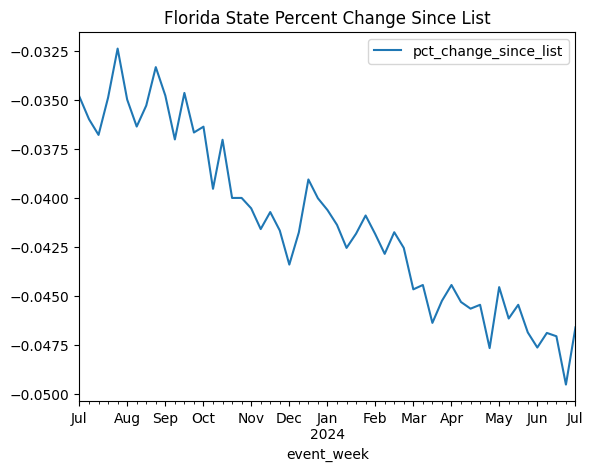

In [24]:
# change since original list price
# get florida average price changes
trending_date = '2023-07-01'
col = 'pct_change_since_list'
changes = paired_w_prop.loc[paired_w_prop['event_week']>=trending_date]
florida = changes.groupby('event_week')[col].median().reset_index()
florida['city'] = 'Florida'
florida.plot(x='event_week', y=col, title='Florida State Percent Change Since List', kind='line')

<Axes: title={'center': 'Single Family Homes Change since List'}, xlabel='event_week'>

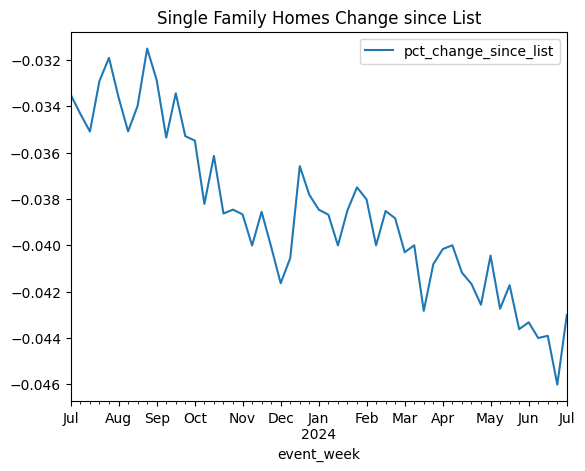

In [25]:
# sfh
sfh = changes.loc[changes['property_type']=='SINGLE_FAMILY']
sfh = sfh.groupby('event_week')[col].median().reset_index()
sfh['city'] = 'Single Family Homes'
sfh.plot(x='event_week', y=col, title='Single Family Homes Change since List', kind='line')

<Axes: title={'center': 'Condo Change since List'}, xlabel='event_week'>

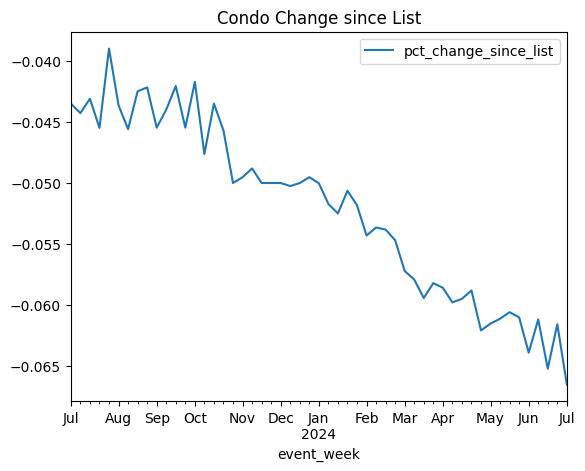

In [26]:
# condos
condos = changes.loc[changes['property_type']=='CONDO']
condos = condos.groupby('event_week')[col].median().reset_index()
condos['city'] = 'Condos'
condos.plot(x='event_week', y=col, title='Condo Change since List', kind='line')

<Axes: title={'center': 'New Construction Change since List'}, xlabel='event_week'>

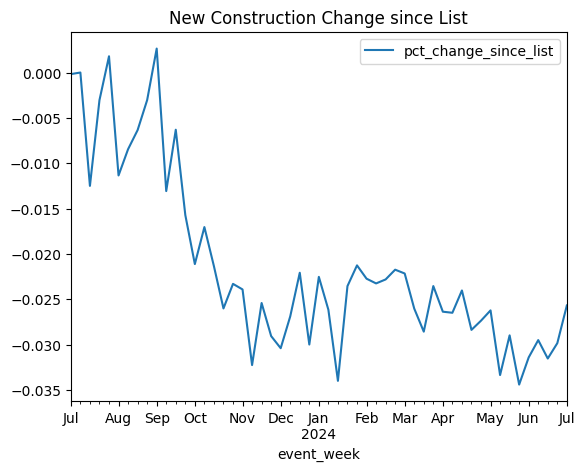

In [27]:
# new construction
new_construction = changes.loc[changes['year_built']>=2022]
new_construction = new_construction.groupby('event_week')[col].median().reset_index()
new_construction['city'] = 'New Construction'
new_construction.plot(x='event_week', y=col, title='New Construction Change since List', kind='line')

In [28]:
all_price_changes = pd.concat([florida, sfh, condos, new_construction])

In [29]:
max_date_for_chart = all_price_changes['event_week'].max().date()
max_date_for_chart = max_date_for_chart.strftime('%B %d, %Y')

# Create the line chart using Plotly Express
fig = px.line(
    all_price_changes,
    x='event_week',
    y=col,
    color='city',
    line_group='city',
    labels={'price_diff_pct': '% Change since Original List'},
    title=f'% Change since Original List by Unit Type'
)

# Update traces to apply specific styles
for trace in fig.data:
    if trace.name == 'Florida':
        trace.update(
            line=dict(color='red', width=4),
            opacity=1
        )
    else:
        trace.update(
            line=dict(color='lightblue', dash='dash', width=2),
            opacity=0.8
        )
    # Remove text annotations from traces
    trace.update(
        mode='lines'
    )

# Find the latest date in the dataset
latest_date = max(all_price_changes['event_week'])

# Add annotations for each line on the far right
annotations = []
y_positions = []

for trace in fig.data:
    # Get the last y-value for each clean_name
    last_y_value = all_price_changes[
        (all_price_changes['city'] == trace.name) &
        (all_price_changes['event_week'] == latest_date)
    ][col].values[0]
    
    # Only add the annotation if it doesn't overlap with existing annotations
    if not any(abs(last_y_value - y) < 0.001 for y in y_positions):  # Adjust threshold as needed
        annotations.append(dict(
            x=latest_date,
            y=last_y_value,
            xref='x',
            yref='y',
            text=trace.name,
            showarrow=False,
            xanchor='left',
            font=dict(size=12)  # Adjust the font size if needed
        ))
        y_positions.append(last_y_value)

fig.add_layout_image(
        create_labs_logo_dict()
)

# Update layout for axes, title, and other styling
fig.update_layout(
    width=1600,
    height=800,
    xaxis=dict(
        title='',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        # tickangle=style_config['tick_angle'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    yaxis=dict(
        title='% Change in Price since Original List',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        tickformat='.0%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    showlegend=False,  # Remove the legend
    margin=dict(l=40, r=40, t=80, b=40),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    annotations=annotations  # Add annotations
)

fig.show()


In [55]:
# now lets analyze what is happening within condos themselves, by breaking out the condo age by decade
def calc_age(year_built):
    if year_built < 1960:
        return 'Pre-1960'
    elif year_built < 1970:
        return '1960s'
    elif year_built < 1980:
        return '1970s'
    elif year_built < 1990:
        return '1980s'
    elif year_built < 2000:
        return '1990s'
    elif year_built < 2010:
        return '2000s'
    elif year_built < 2020:
        return '2010s'
    else:
        return '2020s'
    
def age_sort_index(age_group):
    if age_group == 'Pre-1960':
        return 1
    elif age_group == '1960s':
        return 2
    elif age_group == '1970s':
        return 3
    elif age_group == '1980s':
        return 4
    elif age_group == '1990s':
        return 5
    elif age_group == '2000s':
        return 6
    elif age_group == '2010s':
        return 7
    else:
        return 8
    
paired_w_prop['age_group'] = paired_w_prop['year_built'].apply(calc_age)
paired_w_prop['age_group_sort_index'] = paired_w_prop['age_group'].apply(age_sort_index)

condos = paired_w_prop.loc[paired_w_prop['property_type']=='CONDO']
sfh = paired_w_prop.loc[paired_w_prop['property_type']=='SINGLE_FAMILY']

condo_agg = condos.groupby(['age_group', 'age_group_sort_index'])['pct_change_since_list'].mean().reset_index(name='avg_pct_change')
sfh_agg = sfh.groupby(['age_group', 'age_group_sort_index'])['pct_change_since_list'].mean().reset_index(name='avg_pct_change')
condo_agg['property_type'] = 'Condo'
sfh_agg['property_type'] = 'Single Family Home'

all_agg = pd.concat([condo_agg, sfh_agg])
all_agg = all_agg.sort_values(['property_type', 'age_group_sort_index'])

In [56]:
# Create the Plotly bar chart
fig = px.bar(
    all_agg,
    x='age_group',
    y='avg_pct_change',
    color='property_type',
    barmode='group',
    labels={'avg_pct_change': 'Percent Change'},
    title='Percent Change Since Original Listing'
)

# Update y-axis to format as percentage to 2 decimal places
fig.update_layout(
    yaxis_tickformat='.2%',
    yaxis_title='Percent Change',
    width=1600,
    height=800,
    xaxis=dict(
        title='',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    yaxis=dict(
        title='Percent Change',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        tickformat='.0%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    margin=dict(l=40, r=40, t=80, b=40),
    showlegend=True,
    legend=dict(
        title='',
        x=1.02,
        y=0,
        xanchor='right',
        yanchor='bottom',
        orientation='h'
    ),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, family='Arial')
    },
)

# Add the logo to the chart
def create_labs_logo_dict():
    return dict(
        source='path_to_logo_image',  # Update with the path to your logo image
        xref='paper', yref='paper',
        x=1, y=1.05,
        sizex=0.1, sizey=0.1,
        xanchor='right', yanchor='bottom'
    )

fig.add_layout_image(
    create_labs_logo_dict()
)

fig.show()

In [67]:
all_agg[['age_group', 'property_type', 'avg_pct_change']].to_csv('florida_change_since_original_list_by_property_type.csv', index=False)

In [32]:
# trend it
condos['event_month'] = condos['event_date'].dt.to_period('M').apply(lambda r: r.start_time)
sfh['event_month'] = sfh['event_date'].dt.to_period('M').apply(lambda r: r.start_time)
condo_trend = condos.groupby(['event_month', 'age_group', 'age_group_sort_index'])['pct_change_since_list'].mean().reset_index()
sfh_trend = sfh.groupby(['event_month', 'age_group', 'age_group_sort_index'])['pct_change_since_list'].mean().reset_index()
condo_all = condos.groupby(['event_month'])['pct_change_since_list'].mean().reset_index()
sfh_all = sfh.groupby(['event_month'])['pct_change_since_list'].mean().reset_index()
condo_all['age_group'] = 'All Condos'
sfh_all['age_group'] = 'All Single Family Homes'

all_condo_trend = pd.concat([condo_trend, condo_all])
all_sfh_trend = pd.concat([sfh_trend, sfh_all])


/var/folders/cs/pgg3ckbn3d397n3_x2b312k80000gn/T/ipykernel_18504/1301199027.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cs/pgg3ckbn3d397n3_x2b312k80000gn/T/ipykernel_18504/1301199027.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
all_condo_trend = all_condo_trend.loc[(all_condo_trend['event_month'] >= '2022-07-01') & (all_condo_trend['event_month'] < '2024-07-01')]
max_date_for_chart = all_condo_trend['event_month'].max().date()
max_date_for_chart = max_date_for_chart.strftime('%B %d, %Y')


col = 'pct_change_since_list'
# Create the line chart using Plotly Express
fig = px.line(
    all_condo_trend,
    x='event_month',
    y=col,
    color='age_group',
    line_group='age_group',
    labels={'pct_change_since_list': '% Change since Original List'},
    title=f'% Change since Original List (Condos by Vintage)'
)

# Update traces to apply specific styles
for trace in fig.data:
    if trace.name == 'All Condos':
        trace.update(
            line=dict(color='red', width=4),
            opacity=1
        )
    else:
        trace.update(
            line=dict(color='lightblue', dash='dash', width=2),
            opacity=0.8
        )
    # Remove text annotations from traces
    trace.update(
        mode='lines'
    )

# Find the latest date in the dataset
latest_date = max(all_condo_trend['event_month'])

# Add annotations for each line on the far right
annotations = []
y_positions = []

for trace in fig.data:
    # Get the last y-value for each clean_name
    last_y_value = all_condo_trend[
        (all_condo_trend['age_group'] == trace.name) &
        (all_condo_trend['event_month'] == latest_date)
    ][col].values[0]
    
    # Only add the annotation if it doesn't overlap with existing annotations
    if not any(abs(last_y_value - y) < 0.0001 for y in y_positions):  # Adjust threshold as needed
        annotations.append(dict(
            x=latest_date,
            y=last_y_value,
            xref='x',
            yref='y',
            text=trace.name,
            showarrow=False,
            xanchor='left',
            font=dict(size=12)  # Adjust the font size if needed
        ))
        y_positions.append(last_y_value)

fig.add_layout_image(
        create_labs_logo_dict()
)

# Update layout for axes, title, and other styling
fig.update_layout(
    width=1600,
    height=800,
    xaxis=dict(
        title='',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        # tickangle=style_config['tick_angle'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    yaxis=dict(
        title='% Change in Price since Original List',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        tickformat='.0%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    showlegend=False,  # Remove the legend
    margin=dict(l=40, r=40, t=80, b=40),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    annotations=annotations  # Add annotations
)

fig.show()


In [60]:
# all_condo_trend.to_csv('florida_condos_change_since_list_by_vintage.csv', index=False)

In [34]:
all_sfh_trend = all_sfh_trend.loc[(all_sfh_trend['event_month'] >= '2022-07-01') & (all_sfh_trend['event_month'] < '2024-07-01')]
max_date_for_chart = all_sfh_trend['event_month'].max().date()
max_date_for_chart = max_date_for_chart.strftime('%B %d, %Y')


col = 'pct_change_since_list'
# Create the line chart using Plotly Express
fig = px.line(
    all_sfh_trend,
    x='event_month',
    y=col,
    color='age_group',
    line_group='age_group',
    labels={'pct_change_since_list': '% Change since Original List'},
    title=f'% Change since Original List (Single Family Homes by Vintage)'
)

# Update traces to apply specific styles
for trace in fig.data:
    if trace.name == 'All Single Family Homes':
        trace.update(
            line=dict(color='red', width=4),
            opacity=1
        )
    else:
        trace.update(
            line=dict(color='lightblue', dash='dash', width=2),
            opacity=0.8
        )
    # Remove text annotations from traces
    trace.update(
        mode='lines'
    )

# Find the latest date in the dataset
latest_date = max(all_sfh_trend['event_month'])

# Add annotations for each line on the far right
annotations = []
y_positions = []

for trace in fig.data:
    # Get the last y-value for each clean_name
    last_y_value = all_sfh_trend[
        (all_sfh_trend['age_group'] == trace.name) &
        (all_sfh_trend['event_month'] == latest_date)
    ][col].values[0]
    
    # Only add the annotation if it doesn't overlap with existing annotations
    if not any(abs(last_y_value - y) < 0.0001 for y in y_positions):  # Adjust threshold as needed
        annotations.append(dict(
            x=latest_date,
            y=last_y_value,
            xref='x',
            yref='y',
            text=trace.name,
            showarrow=False,
            xanchor='left',
            font=dict(size=12)  # Adjust the font size if needed
        ))
        y_positions.append(last_y_value)

fig.add_layout_image(
        create_labs_logo_dict()
)

# Update layout for axes, title, and other styling
fig.update_layout(
    width=1600,
    height=800,
    xaxis=dict(
        title='',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        # tickangle=style_config['tick_angle'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    yaxis=dict(
        title='% Change in Price since Original List',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        tickformat='.0%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    showlegend=False,  # Remove the legend
    margin=dict(l=40, r=40, t=80, b=40),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    annotations=annotations  # Add annotations
)

fig.show()


<Axes: title={'center': 'Florida State Price Change (%)'}, xlabel='event_week'>

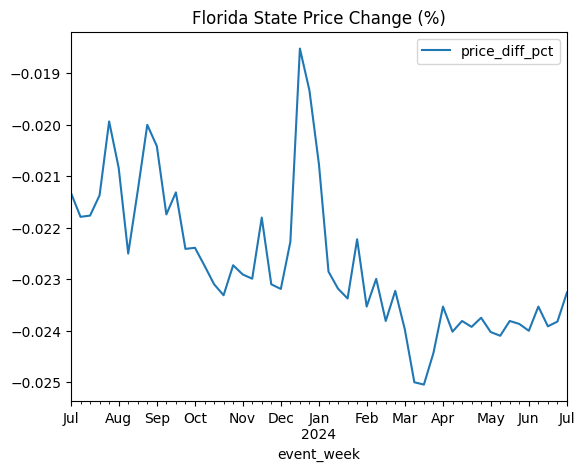

In [35]:
# get florida average price changes
trending_date = '2023-07-01'
changes = paired_w_prop.loc[paired_w_prop['event_week']>=trending_date]
florida = changes.groupby('event_week')['price_diff_pct'].median().reset_index()
florida['city'] = 'Florida'
florida.plot(x='event_week', y='price_diff_pct', title='Florida State Price Change (%)', kind='line')

<Axes: title={'center': 'Single Family Homes Price Change (%)'}, xlabel='event_week'>

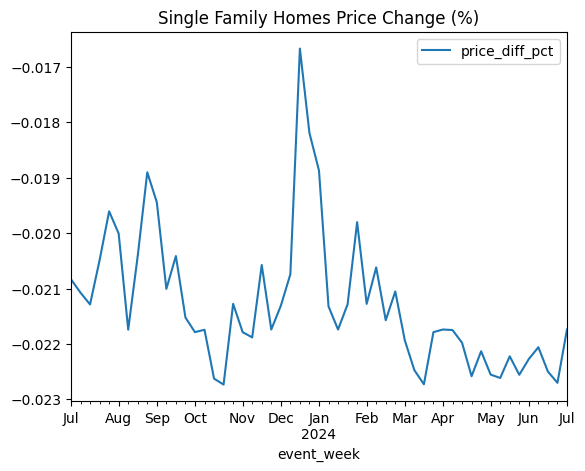

In [36]:
# sfh
sfh = changes.loc[changes['property_type']=='SINGLE_FAMILY']
sfh = sfh.groupby('event_week')['price_diff_pct'].median().reset_index()
sfh['city'] = 'Single Family Homes'
sfh.plot(x='event_week', y='price_diff_pct', title='Single Family Homes Price Change (%)', kind='line')

<Axes: title={'center': 'Condos Price Change (%)'}, xlabel='event_week'>

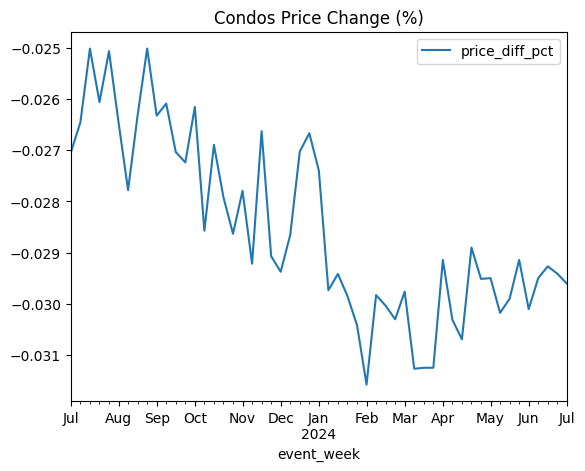

In [37]:
# condos
condos = changes.loc[changes['property_type']=='CONDO']
condos = condos.groupby('event_week')['price_diff_pct'].median().reset_index()
condos['city'] = 'Condos'
condos.plot(x='event_week', y='price_diff_pct', title='Condos Price Change (%)', kind='line')

<Axes: title={'center': 'New Construction Price Change (%)'}, xlabel='event_week'>

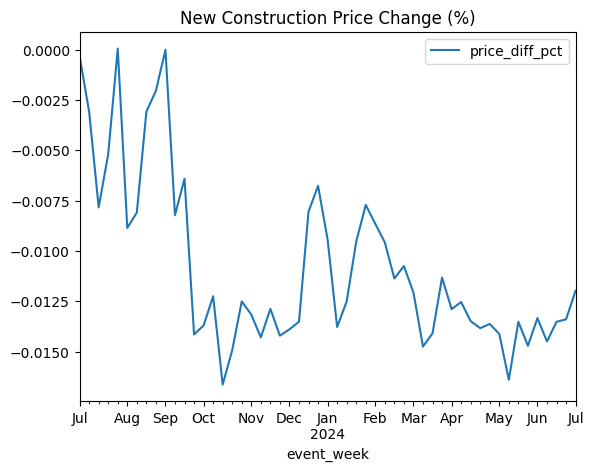

In [38]:
# new construction
new_construction = changes.loc[changes['year_built']>=2022]
new_construction = new_construction.groupby('event_week')['price_diff_pct'].median().reset_index()
new_construction['city'] = 'New Construction'
new_construction.plot(x='event_week', y='price_diff_pct', title='New Construction Price Change (%)', kind='line')

In [39]:
# bring them all together
all_price_changes = pd.concat([florida, sfh, condos, new_construction])

In [61]:
max_date_for_chart = all_price_changes['event_week'].max().date()
max_date_for_chart = max_date_for_chart.strftime('%B %d, %Y')

# Create the line chart using Plotly Express
fig = px.line(
    all_price_changes,
    x='event_week',
    y='price_diff_pct',
    color='city',
    line_group='city',
    labels={'price_diff_pct': '% Change in each Price Drop'},
    title=f'How Much Do Prices Drop in Florida when Changed?',
)

# Update traces to apply specific styles
for trace in fig.data:
    if trace.name == 'Florida':
        trace.update(
            line=dict(color='red', width=4),
            opacity=1
        )
    else:
        trace.update(
            line=dict(color='lightblue', dash='dash', width=2),
            opacity=0.8
        )
    # Remove text annotations from traces
    trace.update(
        mode='lines'
    )

# Find the latest date in the dataset
latest_date = max(all_price_changes['event_week'])

# Add annotations for each line on the far right
annotations = []
y_positions = []

for trace in fig.data:
    # Get the last y-value for each clean_name
    last_y_value = all_price_changes[
        (all_price_changes['city'] == trace.name) &
        (all_price_changes['event_week'] == latest_date)
    ]['price_diff_pct'].values[0]
    
    # Only add the annotation if it doesn't overlap with existing annotations
    if not any(abs(last_y_value - y) < 0.001 for y in y_positions):  # Adjust threshold as needed
        annotations.append(dict(
            x=latest_date,
            y=last_y_value,
            xref='x',
            yref='y',
            text=trace.name,
            showarrow=False,
            xanchor='left',
            font=dict(size=12)  # Adjust the font size if needed
        ))
        y_positions.append(last_y_value)

fig.add_layout_image(
        create_labs_logo_dict()
)

# Update layout for axes, title, and other styling
fig.update_layout(
    width=1600,
    height=800,
    xaxis=dict(
        title='',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        # tickangle=style_config['tick_angle'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    yaxis=dict(
        title='% Price Reductions',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        tickformat='.0%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    showlegend=False,  # Remove the legend
    margin=dict(l=40, r=40, t=80, b=40),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    annotations=annotations  # Add annotations
)

fig.show()


In [63]:
# all_price_changes = all_price_changes.rename(columns={'city': 'type'})
# all_price_changes.to_csv('florida_price_changes_since_list_by_unit_type.csv', index=False)

### Show days b/w price changes and the price change itself

<Axes: title={'center': 'Florida State Price Change (%)'}, xlabel='event_week'>

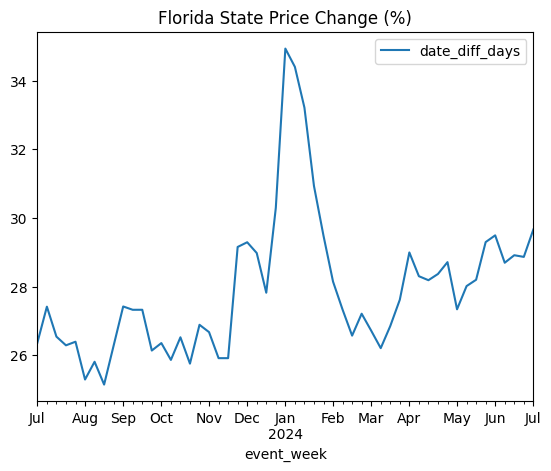

In [41]:
# get florida average price changes
changes = paired_w_prop.loc[paired_w_prop['event_week']>=trending_date]
florida = changes.groupby('event_week')['date_diff_days'].mean().reset_index()
florida['city'] = 'Florida'
florida.plot(x='event_week', y='date_diff_days', title='Florida State Price Change (%)', kind='line')

<Axes: title={'center': 'Single Family Homes Price Change (%)'}, xlabel='event_week'>

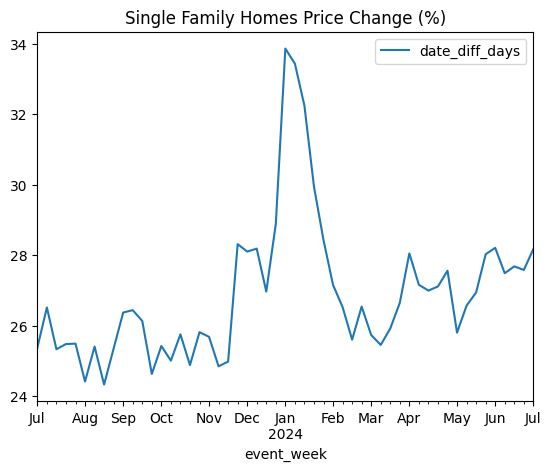

In [42]:
# sfh
sfh = changes.loc[changes['property_type']=='SINGLE_FAMILY']
sfh = sfh.groupby('event_week')['date_diff_days'].mean().reset_index()
sfh['city'] = 'Single Family Homes'
sfh.plot(x='event_week', y='date_diff_days', title='Single Family Homes Price Change (%)', kind='line')

<Axes: title={'center': 'Condos Price Change (%)'}, xlabel='event_week'>

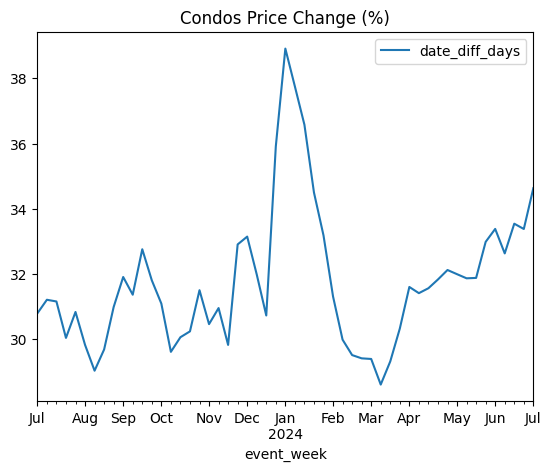

In [43]:
# condos
condos = changes.loc[changes['property_type']=='CONDO']
condos = condos.groupby('event_week')['date_diff_days'].mean().reset_index()
condos['city'] = 'Condos'
condos.plot(x='event_week', y='date_diff_days', title='Condos Price Change (%)', kind='line')

<Axes: title={'center': 'New Construction Price Change (%)'}, xlabel='event_week'>

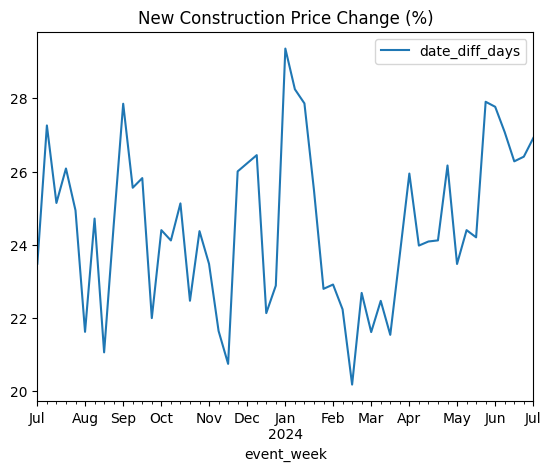

In [44]:
# new construction
new_construction = changes.loc[changes['year_built']>=2022]
new_construction = new_construction.groupby('event_week')['date_diff_days'].mean().reset_index()
new_construction['city'] = 'New Construction'
new_construction.plot(x='event_week', y='date_diff_days', title='New Construction Price Change (%)', kind='line')

In [45]:
# bring them all together
all_day_changes = pd.concat([florida, sfh, condos, new_construction])

In [46]:
max_date_for_chart = all_day_changes['event_week'].max().date()
max_date_for_chart = max_date_for_chart.strftime('%B %d, %Y')

# Create the line chart using Plotly Express
fig = px.line(
    all_day_changes,
    x='event_week',
    y='date_diff_days',
    color='city',
    line_group='city',
    labels={'date_diff_days': 'Days b/w Price Changes'},
    title=f'Days b/w Price Changes'
)

# Update traces to apply specific styles
for trace in fig.data:
    if trace.name == 'Florida':
        trace.update(
            line=dict(color='red', width=4),
            opacity=1
        )
    else:
        trace.update(
            line=dict(color='lightblue', dash='dash', width=2),
            opacity=0.8
        )
    # Remove text annotations from traces
    trace.update(
        mode='lines'
    )

# Find the latest date in the dataset
latest_date = max(all_day_changes['event_week'])

# Add annotations for each line on the far right
annotations = []
y_positions = []

for trace in fig.data:
    # Get the last y-value for each clean_name
    last_y_value = all_day_changes[
        (all_day_changes['city'] == trace.name) &
        (all_day_changes['event_week'] == latest_date)
    ]['date_diff_days'].values[0]
    
    # Only add the annotation if it doesn't overlap with existing annotations
    if not any(abs(last_y_value - y) < 0.001 for y in y_positions):  # Adjust threshold as needed
        annotations.append(dict(
            x=latest_date,
            y=last_y_value,
            xref='x',
            yref='y',
            text=trace.name,
            showarrow=False,
            xanchor='left',
            font=dict(size=12)  # Adjust the font size if needed
        ))
        y_positions.append(last_y_value)

fig.add_layout_image(
        create_labs_logo_dict()
)

# Update layout for axes, title, and other styling
fig.update_layout(
    width=1600,
    height=800,
    xaxis=dict(
        title='',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        # tickangle=style_config['tick_angle'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    yaxis=dict(
        title='Days b/w Price Changes',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        # tickformat='.0%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    showlegend=False,  # Remove the legend
    margin=dict(l=40, r=40, t=80, b=40),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    annotations=annotations  # Add annotations
)

fig.show()


In [47]:
# total price reduction vs current
# i.e. what was the starting price of the unit and now the current price, what is that delta

# count the number of recrods by parcl_property_id, ordered by date
# get the first and last price for each parcl_property_id
changes.head()

,parcl_property_id,event_date,event_name,price,event_date_next,event_name_next,price_next,price_diff,price_diff_pct,date_diff_days,...,latitude,longitude,year_built,property_type,min_date_diff,num_changes,first_price,pct_change_since_list,age_group,age_group_sort_index
0,48699632,2024-02-14,LISTED_SALE,1150000.0,2024-03-08,PRICE_CHANGE,1100000.0,-50000.0,-0.043478,23,...,25.789748,-80.147771,1972.0,CONDO,23,1,1150000.0,-0.043478,1970s,3
1,48699632,2024-03-08,PRICE_CHANGE,1100000.0,2024-04-24,PRICE_CHANGE,1040000.0,-60000.0,-0.054545,47,...,25.789748,-80.147771,1972.0,CONDO,47,2,1150000.0,-0.095652,1970s,3
4,48699849,2024-02-15,LISTED_SALE,249000.0,2024-03-05,PRICE_CHANGE,239000.0,-10000.0,-0.040161,19,...,25.826068,-80.338993,2007.0,CONDO,19,3,270000.0,-0.114815,2000s,6
5,48699849,2024-02-16,LISTED_SALE,249000.0,2024-03-05,PRICE_CHANGE,239000.0,-10000.0,-0.040161,18,...,25.826068,-80.338993,2007.0,CONDO,18,4,270000.0,-0.114815,2000s,6
6,48699849,2024-03-05,PRICE_CHANGE,239000.0,2024-04-04,PRICE_CHANGE,228000.0,-11000.0,-0.046025,30,...,25.826068,-80.338993,2007.0,CONDO,30,5,270000.0,-0.155556,2000s,6


In [48]:
trending_date = '2023-07-01'
changes = paired_w_prop.loc[paired_w_prop['event_week']>=trending_date]

<Axes: title={'center': 'Number of Price Changes by Unit (Florida)'}, xlabel='event_week'>

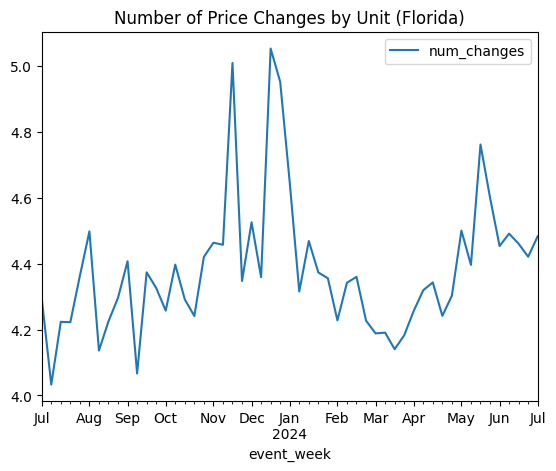

In [49]:
# get florida average price changes
florida = changes.groupby('event_week')['num_changes'].mean().reset_index()
florida['city'] = 'Florida'
florida.plot(x='event_week', y='num_changes', title='Number of Price Changes by Unit (Florida)', kind='line')

<Axes: title={'center': 'Number of Price Changes by Unit (Single Family)'}, xlabel='event_week'>

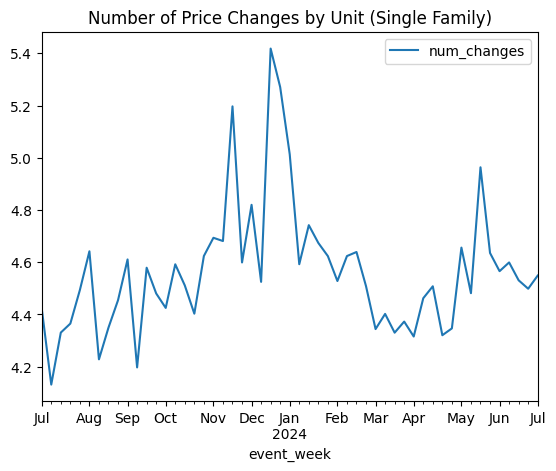

In [50]:
# sfh
sfh = changes.loc[changes['property_type']=='SINGLE_FAMILY']
sfh = sfh.groupby('event_week')['num_changes'].mean().reset_index()
sfh['city'] = 'Single Family Homes'
sfh.plot(x='event_week', y='num_changes', title='Number of Price Changes by Unit (Single Family)', kind='line')

<Axes: title={'center': 'Number of Price Changes by Unit (Condos)'}, xlabel='event_week'>

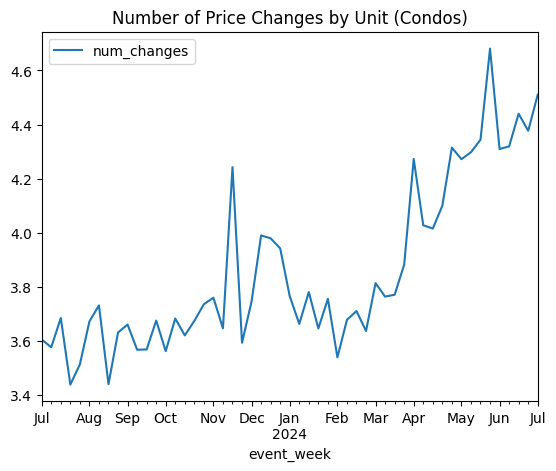

In [51]:
# condos
condos = changes.loc[changes['property_type']=='CONDO']
condos = condos.groupby('event_week')['num_changes'].mean().reset_index()
condos['city'] = 'Condos'
condos.plot(x='event_week', y='num_changes', title='Number of Price Changes by Unit (Condos)', kind='line')

<Axes: title={'center': 'Number of Price Changes by Unit (New Construction)'}, xlabel='event_week'>

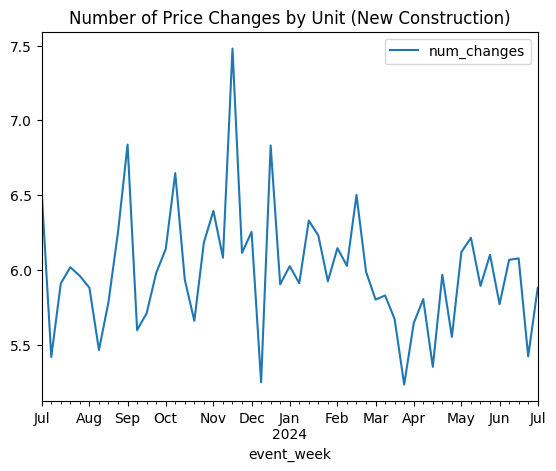

In [52]:
# new construction
new_construction = changes.loc[changes['year_built']>=2022]
new_construction = new_construction.groupby('event_week')['num_changes'].mean().reset_index()
new_construction['city'] = 'New Construction'
new_construction.plot(x='event_week', y='num_changes', title='Number of Price Changes by Unit (New Construction)', kind='line')

In [53]:
# bring them all together
all_day_changes = pd.concat([florida, sfh, condos, new_construction])

In [54]:
max_date_for_chart = all_day_changes['event_week'].max().date()
max_date_for_chart = max_date_for_chart.strftime('%B %d, %Y')

# Create the line chart using Plotly Express
fig = px.line(
    all_day_changes,
    x='event_week',
    y='num_changes',
    color='city',
    line_group='city',
    labels={'num_chnages': 'Avg. Number of Price Changes'},
    title=f'Average Number of Price Changes per Unit'
)

# Update traces to apply specific styles
for trace in fig.data:
    if trace.name == 'Florida':
        trace.update(
            line=dict(color='red', width=4),
            opacity=1
        )
    else:
        trace.update(
            line=dict(color='lightblue', dash='dash', width=2),
            opacity=0.8
        )
    # Remove text annotations from traces
    trace.update(
        mode='lines'
    )

# Find the latest date in the dataset
latest_date = max(all_day_changes['event_week'])

# Add annotations for each line on the far right
annotations = []
y_positions = []

for trace in fig.data:
    # Get the last y-value for each clean_name
    last_y_value = all_day_changes[
        (all_day_changes['city'] == trace.name) &
        (all_day_changes['event_week'] == latest_date)
    ]['num_changes'].values[0]
    
    # Only add the annotation if it doesn't overlap with existing annotations
    if not any(abs(last_y_value - y) < 0.001 for y in y_positions):  # Adjust threshold as needed
        annotations.append(dict(
            x=latest_date,
            y=last_y_value,
            xref='x',
            yref='y',
            text=trace.name,
            showarrow=False,
            xanchor='left',
            font=dict(size=12)  # Adjust the font size if needed
        ))
        y_positions.append(last_y_value)

fig.add_layout_image(
        create_labs_logo_dict()
)

# Update layout for axes, title, and other styling
fig.update_layout(
    width=1600,
    height=800,
    xaxis=dict(
        title='',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        # tickangle=style_config['tick_angle'],
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    yaxis=dict(
        title='# of Price Changes',
        showgrid=style_config['showgrid'],
        gridwidth=style_config['gridwidth'],
        gridcolor=style_config['grid_color'],
        tickfont=style_config['axis_font'],
        zeroline=False,
        # tickformat='.0%',
        linecolor=style_config['line_color_axis'],
        linewidth=style_config['linewidth'],
        titlefont=style_config['title_font_axis']
    ),
    plot_bgcolor=style_config['background_color'],
    paper_bgcolor=style_config['background_color'],
    font=dict(color=style_config['font_color']),
    showlegend=False,  # Remove the legend
    margin=dict(l=40, r=40, t=80, b=40),
    title={
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24)
    },
    annotations=annotations  # Add annotations
)

fig.show()


### Show units with irregular price changes

In [ ]:
# need to reintroduce homes that have no price changes
cols = ['parcl_property_id', 'event_date', 'event_name', 'price', 'city', 'zip5', 'latitude', 'longitude', 'year_built', 'property_type']
no_change = homes[cols]
no_change = no_change.loc[(no_change['event_date']>='2024-05-01') & (~no_change['parcl_property_id'].isin(paired_w_prop['parcl_property_id'].tolist())) & (no_change['price']<2000000) & (no_change['price']>100000) & (no_change['event_name']=='LISTED_SALE')]
no_change['num_changes'] = 0
cols.append('num_changes')

In [ ]:
paired_w_prop.head(1)

In [ ]:
units = paired_w_prop.loc[paired_w_prop['event_date_next']>='2024-05-01']

# now need to get the last value in the sequence
unit_max = units.groupby('parcl_property_id')['num_changes'].max().reset_index()
units = units.merge(unit_max, on=['parcl_property_id', 'num_changes'], how='inner')
units = units.loc[units['num_changes']<=10]

In [ ]:
units = units[cols]
units = pd.concat([units, no_change])

In [ ]:
units.sort_values('num_changes')

In [ ]:
# Create the density mapbox figure
units = units.rename(columns={'num_changes': 'Number of Price Changes'})

fig = px.density_mapbox(
    units,
    lat='latitude',
    lon='longitude',
    z='Number of Price Changes',
    radius=1,  # Adjust radius for density calculation
    zoom=13,
    mapbox_style='mapbox://styles/mapbox/dark-v10',
    color_continuous_scale='thermal'  # Use a red color scale
)

# Update layout
fig.update_layout(
    title=dict(
        text='Density Map of Price Changes by Unit (All Listings in Florida)',
        y=0.98,
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=24, color='white', family='Arial')
    ),
    width=1000,  # Increased width to accommodate the text pane
    height=800,
    margin=dict(l=10, r=10, t=50, b=10),
    coloraxis_colorbar=dict(
        title=dict(
            text='# of Price Changes',
            side='right',
            font=dict(size=14, color='white'),
        ),
        tickfont=dict(color='white'),
        lenmode='fraction',
        len=0.75,
        yanchor='middle',
        y=0.5,
        xanchor='left',
        x=0.05
    ),
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the plot
    paper_bgcolor='#1f2630',  # Dark background for the entire figure
    font=dict(color='white', family='Arial')  # Global font settings
)

# Add logo (assuming create_labs_logo_dict is defined elsewhere)
fig.add_layout_image(
    create_labs_logo_dict(
        color='white',
        xanchor='left',
        yanchor='bottom',
        x=0.05,
        y=0,
        sizex=0.25,
        sizey=0.25,
    ),
)

# Show figure
fig.show()

### Show units with irregular price changes

In [ ]:
units.head()

In [ ]:
import plotly.express as px

mapbox_access_token = 'pk.eyJ1IjoiZGF0YXdyZXN0bGVyLXBhcmNsbGFicyIsImEiOiJjbHZ2bTRidGUxdndtMndvNnI5eGY5dDVoIn0.wXcsWmRjcDAlutloLezm5Q'

# Define a custom marker size based on 'Number of Price Changes'
units['marker_size'] = units['Number of Price Changes'].apply(lambda x: 1.5 if x in [0, 1, 2] else 5)

px.set_mapbox_access_token(mapbox_access_token)

# Create the scatter mapbox figure
fig = px.scatter_mapbox(
    units,
    lat='latitude',
    lon='longitude',
    color='Number of Price Changes',
    category_orders={'Number of Price Changes': ['1', '2', '3']},
    color_continuous_scale='thermal',  # Use a red color scale
    # size='marker_size',
    zoom=13,
    mapbox_style='mapbox://styles/mapbox/dark-v10',  # Dark background
)

# Update hover template
fig.update_traces(
    hovertemplate='%{hovertext}',
    marker=dict(
        size=units['marker_size'].tolist(),
        opacity=units['marker_size'].apply(lambda x: 0.3 if x == 1.5 else 0.9)
    )
)

# Update layout
fig.update_layout(
    title=dict(
        text='Number of Price Changes (Active Listings)',
        y=0.98,
        x=0.5,
        xanchor='center',
        yanchor='top',
        font=dict(size=24, color='white', family='Arial')
    ),
    width=1000,  # Increased width to accommodate the text pane
    height=800,
    margin=dict(l=10, r=10, t=50, b=10),
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Transparent background for the plot
    paper_bgcolor='#1f2630',  # Dark background for the entire figure
    font=dict(color='white', family='Arial')  # Global font settings
)

# Update coloraxis for the continuous color scale legend
fig.update_coloraxes(colorbar=dict(
    title=dict(
        text='# of Price Changes',
        side='right',
        font=dict(size=14, color='white')
    ),
    tickfont=dict(color='white'),
    lenmode='fraction',
    len=0.75,
    yanchor='middle',
    y=0.5,
    xanchor='left',
    x=0.05
))

# Add logo (assuming create_labs_logo_dict is defined elsewhere)
fig.add_layout_image(
    create_labs_logo_dict(
        color='white',
        xanchor='left',
        yanchor='bottom',
        x=0.05,
        y=0,
        sizex=0.25,
        sizey=0.25,
    ),
)

# Show figure
fig.show()
